In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.simulation import Simulation
from tardis.io.config_reader import Configuration
from tardis.io.atom_data import AtomData

from astropy import units as u, constants as const

from stardis.plasma import AlphaLine, HMinusDensity, TracingNus, create_splasma
from stardis.opacities import calc_tau_h_minus, calc_tau_e, calc_tau_nus, calc_hminus_density, calc_tau_photo
from stardis.io import read_marcs_to_fv
from stardis.raytrace import calc_weights

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

(1000.0, 9000.0)

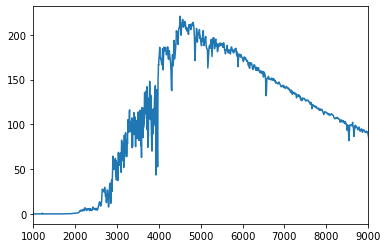

In [2]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(1000, 9000)

## Model & Atomic Data

In [3]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
marcs_model_fv, marcs_abundances_all, temps = read_marcs_to_fv('data/marcs/sun.mod', adata, 30)
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Plasma

In [4]:
tracing_wavelength = np.arange(1000, 10000, 10) * u.Angstrom
tracing_nus = tracing_wavelength.to(u.Hz, u.spectral())

splasma = create_splasma(marcs_model_fv, marcs_abundances_all, adata, tracing_nus)

In [5]:
tw = tracing_nus.to(u.AA, u.spectral())

## RT Calculation

In [6]:
tau_h_minus = calc_tau_h_minus(
    splasma,
    marcs_model_fv,
    tracing_nus,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
    tracing_wavelength=tracing_wavelength
)

UnitConversionError: '' (dimensionless) and 'Angstrom' (length) are not convertible

In [ ]:
# alpha value (=n x sigma) of each line for all 55 cells
# shape of splasma.alpha_line: (74, 55), splasma has 74 lines (aka atomic transitions)
alpha_line = splasma.alpha_line.reset_index(drop=True).values[::-1]
delta_tau_lines = alpha_line * marcs_model_fv.cell_length.values # shape: (74, 55)

In [ ]:
#h_minus_density = calc_hminus_density(
#    h_neutral_density=splasma.ion_number_density.loc[(1, 0)].values,
 #   temperature=marcs_model_fv.t.values * u.K,
  #  electron_density=splasma.electron_densities.values,
   # )

In [ ]:
tau_e = calc_tau_e(splasma,marcs_model_fv,tracing_nus)

In [ ]:
len(marcs_model_fv)

In [ ]:
len(tracing_nus)

In [ ]:
tau_h_minus.shape, delta_tau_lines.shape, tau_e.shape

In [ ]:
# transition doesn't happen at a specific nu due to several factors (changing temperatires, doppler shifts, relativity, etc.)
# so we take a window 2e11 Hz wide - if nu falls within that, we consider it

lines_nu = splasma.lines.nu.values[::-1] # reverse to bring them to ascending order

# search_sorted finds the index before which a (tracing_nu +- 1e11) can be inserted 
# in lines_nu array to maintain its sort order
line_id_starts = lines_nu.searchsorted(tracing_nus.value-1e11)
line_id_ends = lines_nu.searchsorted(tracing_nus.value+1e11)

### Source function

In [ ]:
# bb shape: (56, 800000), calculated at each cell boundary
bb_prefactor = (2 * const.h.cgs * tracing_nus ** 3) / const.c.cgs ** 2
bb = bb_prefactor / (
    np.exp(
        (
            (const.h.cgs * tracing_nus)
            / (const.k_B.cgs * temps * u.K)
        ).value
    )
    - 1
)

In [ ]:
tw_cm = tracing_wavelength.to("cm")

In [ ]:
bbw_prefactor = (2 * const.h.cgs * const.c.cgs ** 2) / (tracing_wavelength) ** 5
bbw = bbw_prefactor / (
    np.exp(
        (
            (const.h.cgs * const.c.cgs)
            / (const.k_B.cgs * tracing_wavelength * temps * u.K)
        )
    )
    - 1
) * 1e-7

In [ ]:
tw_cm

In [ ]:
plt.plot(tracing_wavelength,bbw[0])

In [ ]:
plt.plot(tracing_wavelength,bb[0]*tracing_nus/tracing_wavelength**2)

In [ ]:
for i in range(55):
    plt.plot(tracing_wavelength,bbw[i])

In [ ]:
for i in range(55):
    plt.plot(tracing_nus,bb[i])

In [ ]:
bb.shape

In [ ]:
source = bb[1:].value 
delta_source = bb.diff(axis=0).value  # for cells, not boundary

### RT Equation

In [ ]:
tau_photo_H = 7.91e-18 * splasma.level_number_density.loc[(1,0,1)] * marcs_model_fv.cell_length.values

tau_photo_C = 7.91e-18/6**2 * splasma.level_number_density.loc[(6,0,1)] * marcs_model_fv.cell_length.values

tau_photo_Si = 7.91e-18/14**2 * splasma.level_number_density.loc[(14,0,1)] * marcs_model_fv.cell_length.values

tau_photo_Mg = 7.91e-18/12**2 * splasma.level_number_density.loc[(12,0,1)] * marcs_model_fv.cell_length.values

tau_photo_Al = 7.91e-18/13**2 * splasma.level_number_density.loc[(13,0,1)] * marcs_model_fv.cell_length.values

tau_photo_C/tau_photo_H;

In [ ]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu[0] = bb[0]  # the innermost boundary is photosphere
num_of_shells = len(I_nu) - 1
tau_photo_H_fn = calc_tau_photo(splasma,marcs_model_fv,tracing_nus,(1,0,1),7.91e-18,8.22e14)

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        #tau_nus = np.zeros(I_nu.shape[0] - 1)
        tau_nus = calc_tau_nus(delta_tau, delta_nu)

    else:
        tau_nus = np.zeros(I_nu.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        cur_tau_h_minus = tau_h_minus[j,i]
        curr_tau_e = tau_e[j,i]
        curr_tau_photo = 0
        #curr_tau_rayleigh = tau_rayleigh[j] * nu.value**4
        curr_tau_photo += tau_photo_H_fn[j,i]
        if nu.value>1.7e16:
            curr_tau_photo += tau_photo_C[j] * (nu.value/1.7e16)**(-3)
        if nu.value>1.2e16:
            curr_tau_photo += tau_photo_Si[j] * (nu.value/1.2e16)**(-3)
        if nu.value>1.2e16:
            curr_tau_photo += tau_photo_Mg[j] * (nu.value/1.2e16)**(-3)
        if nu.value>1.2e16:
            curr_tau_photo += tau_photo_Al[j] * (nu.value/1.2e16)**(-3)
        delta_tau_nu = tau_nus[j] + cur_tau_h_minus + curr_tau_photo + curr_tau_e #+ tauross[j] seems to improve
        w0, w1 = calc_weights(delta_tau_nu)

        if tau_nus[j] == 0:
            second_term = 0
        else:
            second_term = w1 * delta_source[j, i] / delta_tau_nu

        I_nu[j + 1, i] = (1 - w0) * I_nu[j, i] + w0 * source[j, i] + second_term # van Noort 2001 eq 14



### Plotting

In [ ]:
I_lambda = (I_nu[55])*tracing_nus/tracing_wavelength

cur_bb = bb[0]*tracing_nus/tracing_wavelength #TODO: check why 0, shouldn't it be 55 like I_nu?

plt.plot(tracing_wavelength, I_lambda, label="I")
plt.plot(tracing_wavelength, cur_bb, label="BB")
# plt.xlim(4330,4350) # to see 1st feature
# plt.xlim(6500, 6600) # to see last feature
#plt.xlim(2000,10000) 
plt.legend()

In [ ]:
plt.figure(figsize=(10,6))
flux = 2*np.pi*1e-5*ndimage.gaussian_filter1d(I_lambda, 1)
plt.plot(tracing_wavelength, flux, label="F")
plt.plot(sun_spec.wave, sun_spec.flux, label="$F_{sun}$")
plt.plot(tracing_wavelength,bbw[14], label="BB of some temp")

plt.xlim((1000,10000))
plt.legend()

In [ ]:
plt.plot(tracing_wavelength,bbw[17], label="BB of some temp")

In [ ]:
kappaross_diff = -np.diff(marcs_model_fv.kappaross)
kappaross_diff = kappaross_diff
kappaross_diff = np.append(kappaross_diff,marcs_model_fv.kappaross[54])
kappaross_diff

In [ ]:
tauross = kappaross_diff*marcs_model_fv.density*marcs_model_fv.cell_length
tauross

In [ ]:
calc_tau_photo(splasma,marcs_model_fv,tracing_nus,(1,0,1),7.91e-18,8.22e14)